[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ksachdeva/rethinking-tensorflow-probability/blob/master/notebooks/13_models_with_memory.ipynb)

# 13. Models with Memory

In [2]:
import numpy as np
import arviz as az
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from collections import namedtuple

import random
import jax
import jax.numpy as jnp

import tensorflow as tf
from tensorflow_probability.substrates import jax as tfp
tfd = tfp.distributions
tfb = tfp.bijectors
# to use 'sample_distributions'
import tensorflow_probability as xtfp
xtfd = xtfp.distributions
xtfb = xtfp.bijectors

key = tfp.util.SeedStream(529, salt="ch-13")
plt.rcParams['figure.figsize'] = [6, 5]

# TFP often requires 64-bit precision (float64) for certain computations 
# to ensure numerical stability and accuracy, e.g., tfd.Possion.
# jax.config.update("jax_enable_x64", True)

## 13.1 Example: Multilevel tadpoles

##### Code 13.1


Reedfrogs dataset is about the tadpole mortality. The objective will be determine the `surv` out of an initial count, `density`.

Author explains that within each tank there are things that go unmeasured and these unmeasured factors create variation in survival across tanks.

These tanks are an example of **cluster** variable

He argues that both of the approaches - 
    * treat the tanks independetly i.e. each of them have their unique intecepts 
    * treat them togather 

have issues. 

for e.g.

    - unique intecepts will imply that we are not using information from other tanks.
    - all togather will have the problem ignoring varations in baseline survival 
    
A multilevel model, in which we simultaneously estimate both an intercept for each tank and the variation among tanks, is what we want !

This type of a model is called **Varying intercepts** model.
        


In [2]:
d = pd.read_csv("./data/ReedFrogs.csv", sep=";")
d.head(10)

,density,pred,size,surv,propsurv
0,10,no,big,9,0.9
1,10,no,big,10,1.0
2,10,no,big,7,0.7
3,10,no,big,10,1.0
4,10,no,small,9,0.9
5,10,no,small,9,0.9
6,10,no,small,10,1.0
7,10,no,small,9,0.9
8,10,pred,big,4,0.4
9,10,pred,big,9,0.9


##### Code 13.2

Our simple model. This will give us 48 different intercepts. This means that it does not use the information available between each tank

In [3]:
n_tank = d.shape[0]

In [11]:
def model_13_1(density):
	def _generator():
		a = yield tfd.Sample(tfd.Normal(loc=0.0, scale=1.5), sample_shape=n_tank, name='a')
		yield tfd.Binomial(total_count=density, logits=a, name='S')

	return tfd.JointDistributionCoroutineAutoBatched(_generator)

In [12]:
jd_13_1 = model_13_1(d.density.values.astype(np.float32))

In [13]:
jd_13_1_pin = jd_13_1.experimental_pin(S=d.surv.values)

In [14]:
@jax.jit
def run_chain(init_state, seed, step_size=1e-3, num_steps=500, burnin=400):

  def target_log_prob(*states):
    return jd_13_1_pin.unnormalized_log_prob(states)
  
  bijectors = [tfb.Identity()]

  kernel = tfp.mcmc.NoUTurnSampler(
      target_log_prob_fn=target_log_prob,
      step_size=step_size)
  
  kernel = tfp.mcmc.TransformedTransitionKernel(
    inner_kernel=kernel,
    bijector=bijectors)

  kernel = tfp.mcmc.DualAveragingStepSizeAdaptation(
    inner_kernel=kernel,
    num_adaptation_steps=burnin)

  chain_state = tfp.mcmc.sample_chain(
      num_results=num_steps,
      num_burnin_steps=burnin,
      current_state=init_state,
      kernel=kernel,
      seed=seed,
      trace_fn=None)
  
  return chain_state

In [15]:
num_chains = 4
init_state = jd_13_1_pin.sample_unpinned(num_chains, seed=key())
post_1 = run_chain(init_state=init_state, seed=key())

In [16]:
post_1_dict = {k: jnp.moveaxis(v, 0, 1) for k, v in post_1._asdict().items()}
dict_1 = dict(posterior=post_1_dict)
idata_1 = az.from_dict(**dict_1)

In [17]:
az.summary(idata_1, hdi_prob=0.89)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a[0],1.700,0.760,0.541,2.947,0.017,0.014,1988.0,1444.0,1.00
a[1],2.370,0.872,1.097,3.883,0.024,0.018,1311.0,1277.0,1.00
a[2],0.732,0.642,-0.279,1.776,0.011,0.010,3495.0,1484.0,1.00
a[3],2.432,0.917,1.001,3.814,0.024,0.018,1585.0,1389.0,1.00
a[4],1.724,0.752,0.637,2.984,0.018,0.014,1827.0,1387.0,1.00
a[5],1.690,0.745,0.536,2.895,0.017,0.013,2001.0,1474.0,1.00
a[6],2.372,0.873,0.994,3.745,0.023,0.017,1560.0,1210.0,1.00
a[7],1.694,0.753,0.520,2.934,0.017,0.013,2091.0,1298.0,1.00
a[8],-0.367,0.590,-1.319,0.520,0.012,0.011,2544.0,1442.0,1.00
a[9],1.708,0.741,0.383,2.749,0.017,0.014,1984.0,1402.0,1.00


##### Code 13.3

We now build a multilevel model, which adaptively pools information across tanks.

In order to do so, we must make the prior for the parameter **alpha** a function of some new parameters.

Prior itself has priors !


In [18]:
def model_13_2(density):
	def _generator():
		a_bar = yield tfd.Normal(loc=0.0, scale=1.5, name='a_bar')
		sigma = yield tfd.Exponential(rate=1.0, name='sigma')
		a = yield tfd.Sample(
				tfd.Normal(loc=a_bar, scale=sigma), sample_shape=n_tank, name='a')
		yield tfd.Binomial(total_count=density, logits=a, name='S')

	return tfd.JointDistributionCoroutineAutoBatched(_generator)

In [19]:
jd_13_2 = model_13_2(d.density.values.astype(np.float32))

In [20]:
jd_13_2_pin = jd_13_2.experimental_pin(S=d.surv.values)

In [21]:
@jax.jit
def run_chain(init_state, seed, step_size=1e-3, num_steps=500, burnin=400):

  def target_log_prob(*states):
    return jd_13_2_pin.unnormalized_log_prob(states)
  
  bijectors = [tfb.Identity(), tfb.Exp(), tfb.Identity()]

  kernel = tfp.mcmc.NoUTurnSampler(
      target_log_prob_fn=target_log_prob,
      step_size=step_size)
  
  kernel = tfp.mcmc.TransformedTransitionKernel(
    inner_kernel=kernel,
    bijector=bijectors)

  kernel = tfp.mcmc.DualAveragingStepSizeAdaptation(
    inner_kernel=kernel,
    num_adaptation_steps=burnin)

  chain_state = tfp.mcmc.sample_chain(
      num_results=num_steps,
      num_burnin_steps=burnin,
      current_state=init_state,
      kernel=kernel,
      seed=seed,
      trace_fn=None)
  
  return chain_state

In [22]:
num_chains = 4
init_state = jd_13_2_pin.sample_unpinned(num_chains, seed=key())
post_2 = run_chain(init_state=init_state, seed=key())

In [23]:
post_2_dict = {k: jnp.moveaxis(v, 0, 1) for k, v in post_2._asdict().items()}
dict_2 = dict(posterior=post_2_dict)
idata_2 = az.from_dict(**dict_2)

In [24]:
az.summary(idata_2, hdi_prob=0.89)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a[0],2.121,0.881,0.768,3.528,0.032,0.024,802.0,645.0,1.01
a[1],3.083,1.131,1.339,4.837,0.045,0.032,644.0,741.0,1.01
a[2],1.018,0.701,-0.092,2.089,0.018,0.015,1641.0,1160.0,1.00
a[3],3.189,1.158,1.241,4.810,0.045,0.034,731.0,716.0,1.00
a[4],2.153,0.877,0.817,3.449,0.028,0.022,1105.0,671.0,1.00
a[5],2.172,0.901,0.818,3.611,0.027,0.020,1110.0,1217.0,1.00
a[6],3.155,1.143,1.528,5.057,0.046,0.034,677.0,660.0,1.00
a[7],2.102,0.878,0.748,3.470,0.027,0.020,1209.0,962.0,1.00
a[8],-0.169,0.608,-1.125,0.807,0.013,0.012,2306.0,1461.0,1.00
a[9],2.108,0.817,0.797,3.339,0.025,0.019,1131.0,1031.0,1.00


##### Code 13.4

In [27]:
def model_13_1x(density):
	def _generator():
		a = yield xtfd.Sample(xtfd.Normal(loc=0.0, scale=1.5), sample_shape=n_tank, name='a')
		yield xtfd.Binomial(total_count=density, logits=a, name='S')

	return xtfd.JointDistributionCoroutineAutoBatched(_generator)

In [28]:
jd_1x = model_13_1x(d.density.values.astype(np.float32))
ds_1, _ = jd_1x.sample_distributions(value=post_1)
ll_1 = ds_1[-1].log_prob(d.surv.values)
ll_1 = np.moveaxis(ll_1, 0, 1) 

In [29]:
dict_1.update(log_likelihood={'ll': ll_1},
              dims={"ll": ["obs"]},
              coords={"obs": np.arange(len(d.surv.values))})
idata_1 = az.from_dict(**dict_1)

In [26]:
def model_13_2x(density):
	def _generator():
		a_bar = yield xtfd.Normal(loc=0.0, scale=1.5, name='a_bar')
		sigma = yield xtfd.Exponential(rate=1.0, name='sigma')
		a = yield xtfd.Sample(
				xtfd.Normal(loc=a_bar, scale=sigma), sample_shape=n_tank, name='a')
		yield xtfd.Binomial(total_count=density, logits=a, name='S')

	return xtfd.JointDistributionCoroutineAutoBatched(_generator)

In [30]:
jd_2x = model_13_2x(d.density.values.astype(np.float32))
ds_2, _ = jd_2x.sample_distributions(value=post_2)
ll_2 = ds_2[-1].log_prob(d.surv.values)
ll_2 = np.moveaxis(ll_2, 0, 1) 

In [31]:
dict_2.update(log_likelihood={'ll': ll_2},
              dims={"ll": ["obs"]},
              coords={"obs": np.arange(len(d.surv.values))})
idata_2 = az.from_dict(**dict_2)

In [33]:
az.compare({"m13.1": idata_1, "m13.2": idata_2}, ic='waic', scale="deviance")

/Users/jun/miniforge3/envs/dl/lib/python3.10/site-packages/arviz/stats/stats.py:1653: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/Users/jun/miniforge3/envs/dl/lib/python3.10/site-packages/arviz/stats/stats.py:1653: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


,rank,elpd_waic,p_waic,elpd_diff,weight,se,dse,warning,scale
m13.2,0,199.775282,20.836952,0.000000,1.000000e+00,7.146740,0.00000,True,deviance
m13.1,1,214.425759,25.478062,14.650477,4.707346e-14,4.417992,3.88301,True,deviance


##### Code 13.5

In [47]:
sample_a_bar = post_2_dict["a_bar"][0]
jnp.mean(jax.nn.sigmoid(sample_a_bar))

Array(0.7898544, dtype=float32)

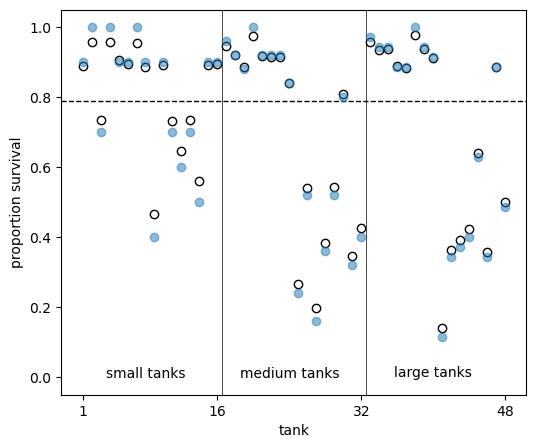

In [48]:
# compute median intercept for each tank
# also transform to probability with logistic

sample_alpha = post_2_dict['a'][0]
propsurv_est = jax.nn.sigmoid(jnp.mean(sample_alpha, 0))

# display raw proportions surviving in each tank
plt.plot(np.arange(1, 49), d.propsurv, "o", alpha=0.5, zorder=3)
plt.gca().set(ylim=(-0.05, 1.05), xlabel="tank", ylabel="proportion survival")
plt.gca().set(xticks=[1, 16, 32, 48], xticklabels=[1, 16, 32, 48])

# overlay posterior means
plt.plot(np.arange(1, 49), propsurv_est, "ko", mfc="w")

sample_a_bar = post_2_dict["a_bar"][0]

# mark posterior mean probability across tanks
plt.gca().axhline(
    y=jnp.mean(jax.nn.sigmoid(sample_a_bar)), c="k", ls="--", lw=1)

# draw vertical dividers between tank densities
plt.gca().axvline(x=16.5, c="k", lw=0.5)
plt.gca().axvline(x=32.5, c="k", lw=0.5)
plt.annotate("small tanks", (8, 0), ha="center")
plt.annotate("medium tanks", (16 + 8, 0), ha="center")
plt.annotate("large tanks", (32 + 8, 0), ha="center")
plt.show()

Here is how to read above plot -

* The dashed line locates the average proportion of survivors across all tanks
* The vertical lines divide tanks with different initial densities of tadpoles: small tanks (10 tad- poles), medium tanks (25), and large tanks (35).
* Empirical proportions of survivors in each tadpole tank, shown by the filled blue points, plotted with the 48 per-tank parameters from the multilevel model, shown by the black circles

In every tank, the posterior mean from the multilevel model is closer to the dashed line than the empir- ical proportion is.

##### Code 13.6

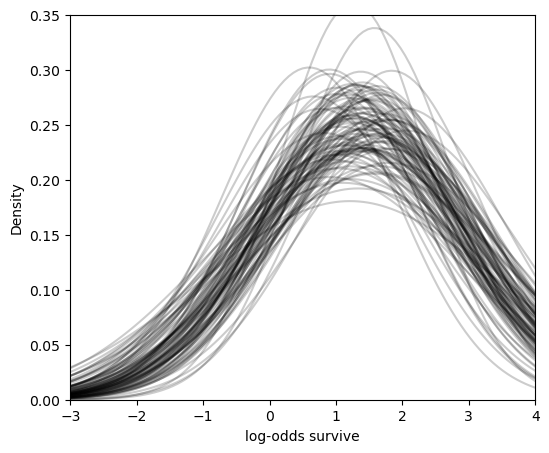

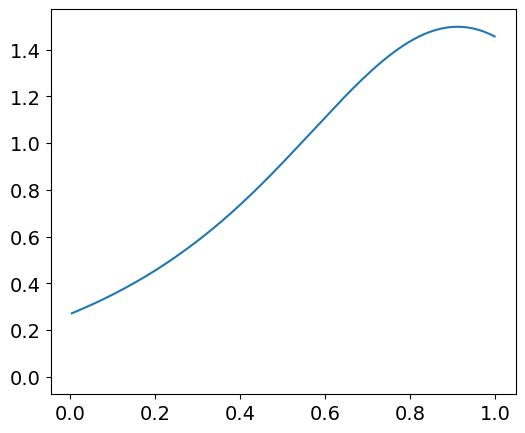

In [50]:
sample_sigma = post_2_dict["sigma"][0]

# show first 100 populations in the posterior
plt.subplot(xlim=(-3, 4), ylim=(0, 0.35), xlabel="log-odds survive", ylabel="Density")

x = np.linspace(-3, 4, 101)
for i in range(100):
    plt.plot(
        x,
        tfd.Normal(sample_a_bar[i], sample_sigma[i]).prob(x),
        "k",
        alpha=0.2,
    )
plt.show()

# sample 8000 imaginary tanks from the posterior distribution
idxs = jax.random.randint(key=key(), shape=8000, minval=0, maxval=499)

sim_tanks = tfd.Normal(sample_a_bar[idxs], sample_sigma[idxs]).sample(seed=key())

# transform to probability and visualize
az.plot_kde(jax.nn.sigmoid(sim_tanks), bw=0.3)
plt.show()

## 13.2 Varying effects and the underlying/overfitting trade-off

### 13.2.1 The model

### 13.2.2 Assign values to the parameters

##### Code 13.7

In [7]:
a_bar = 1.5
sigma = 1.5
nponds = 60
Ni = np.repeat(np.array([5, 10, 25, 35]), repeats=15)

##### Code 13.8

In [9]:
a_pond = tfd.Normal(a_bar, sigma).sample((nponds,), seed=key())

##### Code 13.9

In [15]:
dsim = pd.DataFrame(dict(pond=np.arange(nponds), Ni=Ni, true_a=a_pond))
dsim.head(10)

,pond,Ni,true_a
0,0,5,0.909692
1,1,5,0.687698
2,2,5,3.038762
3,3,5,2.870575
4,4,5,1.377475
5,5,5,0.850885
6,6,5,-0.411248
7,7,5,1.448445
8,8,5,2.256459
9,9,5,1.140994


### 13.2.3 Simulate survivors

##### Code 13.11

In [16]:
dsim["Si"] = tfd.Binomial(total_count=dsim.Ni.values.astype(np.float32), 
                          logits=dsim.true_a.values.astype(np.float32)).sample(seed=key())

In [17]:
dsim.head(10)

,pond,Ni,true_a,Si
0,0,5,0.909692,2.0
1,1,5,0.687698,4.0
2,2,5,3.038762,5.0
3,3,5,2.870575,5.0
4,4,5,1.377475,4.0
5,5,5,0.850885,4.0
6,6,5,-0.411248,1.0
7,7,5,1.448445,5.0
8,8,5,2.256459,5.0
9,9,5,1.140994,3.0


### 13.2.4 Compute the no-pooling estimates

##### Code 13.12

In [18]:
dsim["p_nopool"] = dsim.Si / dsim.Ni

### 13.2.5 Compute partial pooling estimates

##### Code 13.13

In [21]:
sample_shape = dsim.shape[0]

def model_13_3(Ni):
	def _generator():
		a_bar = yield tfd.Normal(loc=0.0, scale=1.5, name='a_bar')
		sigma = yield tfd.Exponential(rate=1.0, name='sigma')
		a_pond = yield tfd.Sample(
				tfd.Normal(loc=a_bar, scale=sigma), 
				sample_shape=sample_shape, name='a_pond')

		Si = yield tfd.Binomial(total_count=Ni, logits=a_pond, name='Si')

	return tfd.JointDistributionCoroutineAutoBatched(_generator)

In [22]:
jd_13_3 = model_13_3(dsim.Ni.values.astype(np.float32))

In [23]:
jd_13_3_pin = jd_13_3.experimental_pin(Si=dsim.Si.values)

In [36]:
@jax.jit
def run_chain(init_state, seed, step_size=1e-3, num_steps=500, burnin=500):

  def target_log_prob(*states):
    return jd_13_3_pin.unnormalized_log_prob(states)
  
  bijectors = [tfb.Identity(), tfb.Exp(), tfb.Identity()]

  kernel = tfp.mcmc.NoUTurnSampler(
      target_log_prob_fn=target_log_prob,
      step_size=step_size)
  
  kernel = tfp.mcmc.TransformedTransitionKernel(
    inner_kernel=kernel,
    bijector=bijectors)

  kernel = tfp.mcmc.DualAveragingStepSizeAdaptation(
    inner_kernel=kernel,
    num_adaptation_steps=burnin)

  chain_state = tfp.mcmc.sample_chain(
      num_results=num_steps,
      num_burnin_steps=burnin,
      current_state=init_state,
      kernel=kernel,
      seed=seed,
      trace_fn=None)
  
  return chain_state

In [33]:
num_chains = 4
init_state = jd_13_3_pin.sample_unpinned(num_chains, seed=key())
post_3 = run_chain(init_state=init_state, seed=key())

In [34]:
post_3_dict = {k: jnp.moveaxis(v, 0, 1) for k, v in post_3._asdict().items()}
dict_3 = dict(posterior=post_3_dict)
idata_3 = az.from_dict(**dict_3)

In [35]:
az.summary(idata_3, hdi_prob=0.89)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a_bar,1.694,0.184,1.379,1.962,0.005,0.004,1338.0,1621.0,1.0
a_pond[0],0.473,0.769,-0.731,1.750,0.018,0.017,1914.0,1219.0,1.0
a_pond[1],1.623,0.852,0.400,3.086,0.022,0.017,1543.0,1274.0,1.0
a_pond[2],2.346,0.907,0.695,3.544,0.025,0.018,1378.0,1120.0,1.0
a_pond[3],2.315,0.928,0.814,3.695,0.026,0.020,1304.0,1058.0,1.0
...,...,...,...,...,...,...,...,...,...
a_pond[56],1.643,0.418,0.954,2.296,0.008,0.006,2918.0,1343.0,1.0
a_pond[57],0.905,0.345,0.329,1.427,0.007,0.005,2553.0,1395.0,1.0
a_pond[58],1.322,0.400,0.690,1.934,0.007,0.006,2979.0,1171.0,1.0
a_pond[59],0.650,0.350,0.109,1.230,0.007,0.006,2490.0,1225.0,1.0


##### Code 13.15

In [40]:
sample_a_pond = post_3_dict["a_pond"][0]
dsim["p_partpool"] = jnp.mean(jax.nn.sigmoid(sample_a_pond), axis=0)

##### Code 13.16

In [42]:
dsim["p_true"] = jax.nn.sigmoid(dsim.true_a.values)

##### Code 13.17

In [43]:
nopool_error = (dsim.p_nopool - dsim.p_true).abs()
partpool_error = (dsim.p_partpool - dsim.p_true).abs()

##### Code 13.18

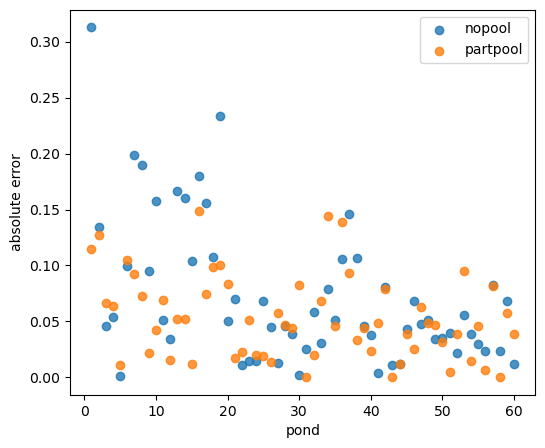

In [44]:
plt.scatter(range(1, 61), nopool_error, label="nopool", alpha=0.8)
plt.gca().set(xlabel="pond", ylabel="absolute error")
plt.scatter(range(1, 61), partpool_error, label="partpool", alpha=0.8)
plt.legend()
plt.show()

## 13.3 More than one type of cluster

### 13.3.1 Multilevel chimpanzees

##### Code 13.21

In [4]:
d = pd.read_csv("./data/Chimpanzees.csv", sep=";")

d["treatment"] = 1 + d.prosoc_left + 2 * d.condition - 1
d["block_id"] = d.block.values - 1
d["actor"] = d.actor.values - 1

In [6]:
def model_13_4(actor, block_id, treatment):
	def _generator():
		# hyper-priors
		a_bar = yield tfd.Normal(loc=0.0, scale=1.5, name='a_bar')
		sigma_a = yield tfd.Exponential(rate=1.0, name='sigma_a')
		sigma_g = yield tfd.Exponential(rate=1.0, name='sigma_g')
		# adaptive priors
		a = yield tfd.Sample(tfd.Normal(loc=a_bar, scale=sigma_a), sample_shape=7, name='a')
		g = yield tfd.Sample(tfd.Normal(loc=0.0, scale=sigma_g), sample_shape=6, name='g')
		b = yield tfd.Sample(tfd.Normal(loc=0.0, scale=0.5), sample_shape=4, name='b')

		logit = jnp.take(a, actor) + jnp.take(g, block_id) + jnp.take(b, treatment)
		yield tfd.Bernoulli(logits=logit, name='pulled_left')

	return tfd.JointDistributionCoroutineAutoBatched(_generator)

In [7]:
jd_13_4 = model_13_4(d.actor.values.astype(np.int32), d.block_id.values.astype(np.int32),
                     d.treatment.values.astype(np.int32))

In [8]:
jd_13_4_pin = jd_13_4.experimental_pin(pulled_left=d.pulled_left.values.astype(np.float32))

In [9]:
@jax.jit
def run_chain(init_state, seed, step_size=1e-3, num_steps=500, burnin=400):

  def target_log_prob(*states):
    return jd_13_4_pin.unnormalized_log_prob(states)
  
  bijectors = [tfb.Identity(), tfb.Exp(), tfb.Exp(),
               tfb.Identity(), tfb.Identity(), tfb.Identity()]

  kernel = tfp.mcmc.NoUTurnSampler(
      target_log_prob_fn=target_log_prob,
      step_size=step_size)
  
  kernel = tfp.mcmc.TransformedTransitionKernel(
    inner_kernel=kernel,
    bijector=bijectors)

  kernel = tfp.mcmc.DualAveragingStepSizeAdaptation(
    inner_kernel=kernel,
    num_adaptation_steps=burnin)

  chain_state = tfp.mcmc.sample_chain(
      num_results=num_steps,
      num_burnin_steps=burnin,
      current_state=init_state,
      kernel=kernel,
      seed=seed,
      trace_fn=None)
  
  return chain_state

In [10]:
num_chains = 4
init_state = jd_13_4_pin.sample_unpinned(num_chains, seed=key())
post_4 = run_chain(init_state=init_state, seed=key())

In [11]:
post_4_dict = {k: jnp.moveaxis(v, 0, 1) for k, v in post_4._asdict().items()}
dict_4 = dict(posterior=post_4_dict)
idata_4 = az.from_dict(**dict_4)

In [12]:
az.summary(idata_4, hdi_prob=0.89)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a[0],-0.344,0.355,-0.891,0.231,0.016,0.012,471.0,924.0,1.02
a[1],4.562,1.070,2.736,6.009,0.055,0.039,366.0,484.0,1.05
a[2],-0.635,0.395,-1.221,0.035,0.064,0.046,38.0,126.0,1.08
a[3],-0.643,0.365,-1.207,-0.062,0.021,0.015,294.0,1064.0,1.03
a[4],-0.362,0.353,-0.936,0.167,0.014,0.010,597.0,980.0,1.01
a[5],0.616,0.361,0.071,1.194,0.017,0.012,432.0,1001.0,1.02
a[6],2.111,0.445,1.426,2.843,0.016,0.011,751.0,639.0,1.02
a_bar,0.641,0.703,-0.475,1.676,0.034,0.024,401.0,702.0,1.02
b[0],-0.157,0.302,-0.621,0.302,0.034,0.024,85.0,666.0,1.04
b[1],0.376,0.295,-0.061,0.826,0.026,0.018,137.0,971.0,1.03


Note that there is variation across parameters when it comes to effective sample size (ess_mean). This is because some parameters spends a lot of time near a boundary. 

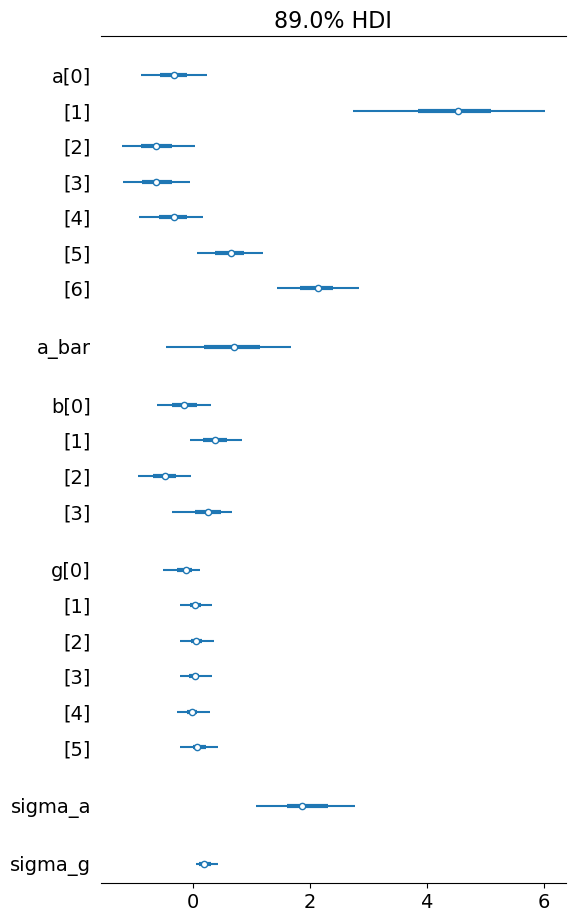

In [13]:
az.plot_forest(idata_4, combined=True, hdi_prob=0.89);

##### Code 13.23

Build a model that ignores block so that we can then compare it with the above model

In [14]:
def model_13_5(actor, treatment):
	def _generator():
		# hyper-priors
		a_bar = yield tfd.Normal(loc=0.0, scale=1.5, name='a_bar')
		sigma_a = yield tfd.Exponential(rate=1.0, name='sigma_a')
		# adaptive priors
		a = yield tfd.Sample(tfd.Normal(loc=a_bar, scale=sigma_a), sample_shape=7, name='a')
		b = yield tfd.Sample(tfd.Normal(loc=0.0, scale=0.5), sample_shape=4, name='b')

		logit = jnp.take(a, actor) + jnp.take(b, treatment)
		yield tfd.Bernoulli(logits=logit, name='pulled_left')

	return tfd.JointDistributionCoroutineAutoBatched(_generator)

In [15]:
jd_13_5 = model_13_5(d.actor.values.astype(np.int32), d.treatment.values.astype(np.int32))

In [16]:
jd_13_5_pin = jd_13_5.experimental_pin(pulled_left=d.pulled_left.values.astype(np.float32))

In [17]:
@jax.jit
def run_chain(init_state, seed, step_size=1e-3, num_steps=500, burnin=400):

  def target_log_prob(*states):
    return jd_13_5_pin.unnormalized_log_prob(states)
  
  bijectors = [tfb.Identity(), tfb.Exp(), tfb.Identity(), tfb.Identity()]

  kernel = tfp.mcmc.NoUTurnSampler(
      target_log_prob_fn=target_log_prob,
      step_size=step_size)
  
  kernel = tfp.mcmc.TransformedTransitionKernel(
    inner_kernel=kernel,
    bijector=bijectors)

  kernel = tfp.mcmc.DualAveragingStepSizeAdaptation(
    inner_kernel=kernel,
    num_adaptation_steps=burnin)

  chain_state = tfp.mcmc.sample_chain(
      num_results=num_steps,
      num_burnin_steps=burnin,
      current_state=init_state,
      kernel=kernel,
      seed=seed,
      trace_fn=None)
  
  return chain_state

In [18]:
num_chains = 4
init_state = jd_13_5_pin.sample_unpinned(num_chains, seed=key())
post_5 = run_chain(init_state=init_state, seed=key())

In [19]:
post_5_dict = {k: jnp.moveaxis(v, 0, 1) for k, v in post_5._asdict().items()}
dict_5 = dict(posterior=post_5_dict)
idata_5 = az.from_dict(**dict_5)

In [20]:
az.summary(idata_5, hdi_prob=0.89)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a[0],-0.359,0.354,-0.909,0.213,0.010,0.008,1382.0,1226.0,1.00
a[1],4.615,1.287,2.786,6.197,0.056,0.041,665.0,488.0,1.00
a[2],-0.647,0.358,-1.182,-0.045,0.009,0.007,1515.0,1520.0,1.00
a[3],-0.651,0.351,-1.207,-0.093,0.009,0.006,1541.0,1667.0,1.00
a[4],-0.355,0.348,-0.878,0.208,0.009,0.007,1603.0,1484.0,1.00
a[5],0.584,0.353,0.032,1.160,0.009,0.006,1646.0,1431.0,1.00
a[6],2.103,0.462,1.326,2.818,0.011,0.008,1741.0,1428.0,1.00
a_bar,0.588,0.696,-0.526,1.647,0.017,0.014,1627.0,1347.0,1.01
b[0],-0.135,0.304,-0.585,0.375,0.008,0.006,1578.0,1211.0,1.00
b[1],0.392,0.302,-0.083,0.892,0.008,0.006,1537.0,1391.0,1.00


##### Code 13.24

In [21]:
def model_13_4x(actor, block_id, treatment):
	def _generator():
		# hyper-priors
		a_bar = yield xtfd.Normal(loc=0.0, scale=1.5, name='a_bar')
		sigma_a = yield xtfd.Exponential(rate=1.0, name='sigma_a')
		sigma_g = yield xtfd.Exponential(rate=1.0, name='sigma_g')
		# adaptive priors
		a = yield xtfd.Sample(xtfd.Normal(loc=a_bar, scale=sigma_a), sample_shape=7, name='a')
		g = yield xtfd.Sample(xtfd.Normal(loc=0.0, scale=sigma_g), sample_shape=6, name='g')
		b = yield xtfd.Sample(xtfd.Normal(loc=0.0, scale=0.5), sample_shape=4, name='b')

		logit = tf.gather(a, actor) + tf.gather(g, block_id) + tf.gather(b, treatment)
		yield xtfd.Bernoulli(logits=logit, name='pulled_left')

	return xtfd.JointDistributionCoroutineAutoBatched(_generator)

In [22]:
jd_4x = model_13_4x(d.actor.values.astype(np.int32), d.block_id.values.astype(np.int32),
                     d.treatment.values.astype(np.int32))
ds_4, _ = jd_4x.sample_distributions(value=post_4)
ll_4 = ds_4[-1].log_prob(d.pulled_left.values.astype(np.float32))
ll_4 = np.moveaxis(ll_4, 0, 1) 

In [23]:
dict_4.update(log_likelihood={'ll': ll_4},
              dims={"ll": ["obs"]},
              coords={"obs": np.arange(len(d.pulled_left.values))})
idata_4 = az.from_dict(**dict_4)

In [24]:
def model_13_5x(actor, treatment):
	def _generator():
		# hyper-priors
		a_bar = yield xtfd.Normal(loc=0.0, scale=1.5, name='a_bar')
		sigma_a = yield xtfd.Exponential(rate=1.0, name='sigma_a')
		# adaptive priors
		a = yield xtfd.Sample(xtfd.Normal(loc=a_bar, scale=sigma_a), sample_shape=7, name='a')
		b = yield xtfd.Sample(xtfd.Normal(loc=0.0, scale=0.5), sample_shape=4, name='b')

		logit = tf.gather(a, actor) + tf.gather(b, treatment)
		yield xtfd.Bernoulli(logits=logit, name='pulled_left')

	return xtfd.JointDistributionCoroutineAutoBatched(_generator)

In [25]:
jd_5x = model_13_5x(d.actor.values.astype(np.int32), d.treatment.values.astype(np.int32))
ds_5, _ = jd_5x.sample_distributions(value=post_5)
ll_5 = ds_5[-1].log_prob(d.pulled_left.values.astype(np.float32))
ll_5 = np.moveaxis(ll_5, 0, 1) 

In [26]:
dict_5.update(log_likelihood={'ll': ll_5},
              dims={"ll": ["obs"]},
              coords={"obs": np.arange(len(d.pulled_left.values))})
idata_5 = az.from_dict(**dict_5)

In [27]:
az.compare({"m13.4": idata_4, "m13.5": idata_5}, ic='waic', scale="deviance")

,rank,elpd_waic,p_waic,elpd_diff,weight,se,dse,warning,scale
m13.5,0,530.976480,8.435287,0.000000,1.0,19.173765,0.000000,False,deviance
m13.4,1,532.503967,10.656053,1.527487,0.0,19.311229,1.726081,False,deviance


### 13.3.2 Even more clusters

##### Code 13.25

m13.4 with partial pooling on the treatments

In [28]:
def model_13_6(actor, block_id, treatment):
	def _generator():
		# hyper-priors
		a_bar = yield tfd.Normal(loc=0.0, scale=1.5, name='a_bar')
		sigma_a = yield tfd.Exponential(rate=1.0, name='sigma_a')
		sigma_g = yield tfd.Exponential(rate=1.0, name='sigma_g')
		sigma_b = yield tfd.Exponential(rate=1.0, name='sigma_b')
		# adaptive priors
		a = yield tfd.Sample(tfd.Normal(loc=a_bar, scale=sigma_a), sample_shape=7, name='a')
		g = yield tfd.Sample(tfd.Normal(loc=0.0, scale=sigma_g), sample_shape=6, name='g')
		b = yield tfd.Sample(tfd.Normal(loc=0.0, scale=sigma_b), sample_shape=4, name='b')

		logit = jnp.take(a, actor) + jnp.take(g, block_id) + jnp.take(b, treatment)
		yield tfd.Bernoulli(logits=logit, name='pulled_left')

	return tfd.JointDistributionCoroutineAutoBatched(_generator)

In [29]:
jd_13_6 = model_13_6(d.actor.values.astype(np.int32), d.block_id.values.astype(np.int32),
                     d.treatment.values.astype(np.int32))

In [30]:
jd_13_6_pin = jd_13_6.experimental_pin(pulled_left=d.pulled_left.values.astype(np.float32))

In [31]:
@jax.jit
def run_chain(init_state, seed, step_size=1e-3, num_steps=500, burnin=400):

  def target_log_prob(*states):
    return jd_13_6_pin.unnormalized_log_prob(states)
  
  bijectors = [tfb.Identity(), tfb.Exp(), tfb.Exp(), tfb.Exp(),
               tfb.Identity(), tfb.Identity(), tfb.Identity()]

  kernel = tfp.mcmc.NoUTurnSampler(
      target_log_prob_fn=target_log_prob,
      step_size=step_size)
  
  kernel = tfp.mcmc.TransformedTransitionKernel(
    inner_kernel=kernel,
    bijector=bijectors)

  kernel = tfp.mcmc.DualAveragingStepSizeAdaptation(
    inner_kernel=kernel,
    num_adaptation_steps=burnin)

  chain_state = tfp.mcmc.sample_chain(
      num_results=num_steps,
      num_burnin_steps=burnin,
      current_state=init_state,
      kernel=kernel,
      seed=seed,
      trace_fn=None)
  
  return chain_state

In [32]:
num_chains = 4
init_state = jd_13_6_pin.sample_unpinned(num_chains, seed=key())
post_6 = run_chain(init_state=init_state, seed=key())

In [33]:
post_6_dict = {k: jnp.moveaxis(v, 0, 1) for k, v in post_6._asdict().items()}
dict_6 = dict(posterior=post_6_dict)
idata_6 = az.from_dict(**dict_6)

In [34]:
az.summary(idata_6, hdi_prob=0.89)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a[0],-0.381,0.413,-1.049,0.234,0.015,0.012,788.0,616.0,1.01
a[1],4.562,1.214,2.685,6.320,0.063,0.045,387.0,509.0,1.01
a[2],-0.670,0.426,-1.327,-0.009,0.016,0.012,724.0,628.0,1.00
a[3],-0.674,0.407,-1.287,-0.028,0.015,0.011,804.0,778.0,1.01
a[4],-0.371,0.408,-1.002,0.265,0.015,0.012,767.0,796.0,1.00
a[5],0.566,0.412,-0.058,1.245,0.015,0.011,766.0,662.0,1.00
a[6],2.102,0.520,1.274,2.948,0.021,0.015,637.0,326.0,1.01
a_bar,0.554,0.735,-0.549,1.776,0.031,0.022,570.0,406.0,1.00
b[0],-0.109,0.363,-0.686,0.398,0.014,0.011,648.0,540.0,1.01
b[1],0.387,0.374,-0.203,0.941,0.015,0.012,607.0,243.0,1.01


## 13.4 Divergent transitions and non-centered priors

### 13.4.1 The Devil's Funnel

##### Code 13.26 

In [35]:
def model_13_7():
    def _generator():
        v = yield tfd.Normal(loc=0.0, scale=3.0, name='v')
        yield tfd.Normal(loc=0.0, scale=jnp.exp(v), name='x')

    return tfd.JointDistributionCoroutineAutoBatched(_generator)

In [36]:
jd_13_7 = model_13_7()

In [37]:
@jax.jit
def run_chain(init_state, seed, step_size=1e-3, num_steps=500, burnin=400):

  def target_log_prob(*states):
    return jd_13_7.log_prob(states)
  
  bijectors = [tfb.Identity(), tfb.Identity()]

  kernel = tfp.mcmc.NoUTurnSampler(
      target_log_prob_fn=target_log_prob,
      step_size=step_size)
  
  kernel = tfp.mcmc.TransformedTransitionKernel(
    inner_kernel=kernel,
    bijector=bijectors)

  kernel = tfp.mcmc.DualAveragingStepSizeAdaptation(
    inner_kernel=kernel,
    num_adaptation_steps=burnin)

  chain_state = tfp.mcmc.sample_chain(
      num_results=num_steps,
      num_burnin_steps=burnin,
      current_state=init_state,
      kernel=kernel,
      seed=seed,
      trace_fn=None)
  
  return chain_state

In [38]:
num_chains = 4
init_state = jd_13_7.sample(num_chains, seed=key())
post_7 = run_chain(init_state=init_state, seed=key())

In [39]:
post_7_dict = {k: jnp.moveaxis(v, 0, 1) for k, v in post_7._asdict().items()}
dict_7 = dict(posterior=post_7_dict)
idata_7 = az.from_dict(**dict_7)

In [40]:
az.summary(idata_7, hdi_prob=0.89)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
v,1.067,2.254,-2.554,4.046,0.520,0.374,20.0,16.0,1.18
x,-6.800,52.608,-49.142,20.161,12.083,8.679,18.0,27.0,1.17


##### Code 13.27

TODO: Expected `tfd.Deterministic` works like Stan's `transformed parameters` 

In [74]:
def model_13_7nc():
    def _generator():
        v = yield tfd.Normal(loc=0.0, scale=3.0, name='v')
        z = yield tfd.Normal(loc=0.0, scale=1.0, name='z')
        # yield tfd.Deterministic(z * jnp.exp(v), name='x')

    return tfd.JointDistributionCoroutineAutoBatched(_generator)

In [75]:
jd_13_7nc = model_13_7nc()

In [76]:
@jax.jit
def run_chain(init_state, seed, step_size=1e-3, num_steps=500, burnin=400):

  def target_log_prob(*states):
    return jd_13_7nc.log_prob(states)
  
  bijectors = [tfb.Identity(), tfb.Identity()]#, tfb.Identity()]

  kernel = tfp.mcmc.NoUTurnSampler(
      target_log_prob_fn=target_log_prob,
      step_size=step_size)
  
  kernel = tfp.mcmc.TransformedTransitionKernel(
    inner_kernel=kernel,
    bijector=bijectors)

  kernel = tfp.mcmc.DualAveragingStepSizeAdaptation(
    inner_kernel=kernel,
    num_adaptation_steps=burnin)

  chain_state = tfp.mcmc.sample_chain(
      num_results=num_steps,
      num_burnin_steps=burnin,
      current_state=init_state,
      kernel=kernel,
      seed=seed,
      trace_fn=None)
  
  return chain_state

In [77]:
num_chains = 4
init_state = jd_13_7nc.sample(num_chains, seed=key())
post_7nc = run_chain(init_state=init_state, seed=key())

In [78]:
post_7nc_dict = {k: jnp.moveaxis(v, 0, 1) for k, v in post_7nc._asdict().items()}
dict_7nc = dict(posterior=post_7nc_dict)
idata_7nc = az.from_dict(**dict_7nc)

In [79]:
az.summary(idata_7nc, hdi_prob=0.89)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
v,0.098,3.003,-4.507,4.765,0.108,0.077,800.0,847.0,1.01
z,-0.015,1.026,-1.714,1.585,0.024,0.020,1864.0,1695.0,1.00


### 13.4.2 Non-centered chimpanzees

##### Code 13.29

In [88]:
def model_13_4nc(actor, block_id, treatment):
	def _generator():
		# hyper-priors
		a_bar = yield tfd.Normal(loc=0.0, scale=1.5, name='a_bar')
		sigma_a = yield tfd.Exponential(rate=1.0, name='sigma_a')
		sigma_g = yield tfd.Exponential(rate=1.0, name='sigma_g')
		# adaptive priors
		z = yield tfd.Sample(tfd.Normal(loc=0.0, scale=1.0), sample_shape=7, name='z')
		x = yield tfd.Sample(tfd.Normal(loc=0.0, scale=1.0), sample_shape=6, name='x')
		b = yield tfd.Sample(tfd.Normal(loc=0.0, scale=0.5), sample_shape=4, name='b')

		# reparamertization
		logit = a_bar + sigma_a * jnp.take(z, actor) + \
			sigma_g * jnp.take(x, block_id) + jnp.take(b, treatment)

		yield tfd.Bernoulli(logits=logit, name='pulled_left')

	return tfd.JointDistributionCoroutineAutoBatched(_generator)

In [89]:
jd_13_4nc = model_13_4nc(d.actor.values.astype(np.int32), 
                         d.block_id.values.astype(np.int32),
                         d.treatment.values.astype(np.int32))

In [90]:
jd_13_4nc_pin = jd_13_4nc.experimental_pin(pulled_left=d.pulled_left.values.astype(np.float32))

In [91]:
@jax.jit
def run_chain(init_state, seed, step_size=1e-3, num_steps=500, burnin=400):

  def target_log_prob(*states):
    return jd_13_4nc_pin.unnormalized_log_prob(states)
  
  bijectors = [tfb.Identity(), tfb.Exp(), tfb.Exp(),
               tfb.Identity(), tfb.Identity(), tfb.Identity()]

  kernel = tfp.mcmc.NoUTurnSampler(
      target_log_prob_fn=target_log_prob,
      step_size=step_size)
  
  kernel = tfp.mcmc.TransformedTransitionKernel(
    inner_kernel=kernel,
    bijector=bijectors)

  kernel = tfp.mcmc.DualAveragingStepSizeAdaptation(
    inner_kernel=kernel,
    num_adaptation_steps=burnin)

  chain_state = tfp.mcmc.sample_chain(
      num_results=num_steps,
      num_burnin_steps=burnin,
      current_state=init_state,
      kernel=kernel,
      seed=seed,
      trace_fn=None)
  
  return chain_state

In [92]:
num_chains = 4
init_state = jd_13_4nc_pin.sample_unpinned(num_chains, seed=key())
post_4nc = run_chain(init_state=init_state, seed=key())

In [93]:
post_4nc_dict = {k: jnp.moveaxis(v, 0, 1) for k, v in post_4nc._asdict().items()}
dict_4nc = dict(posterior=post_4nc_dict)
idata_4nc = az.from_dict(**dict_4nc)

In [94]:
az.summary(idata_4nc, hdi_prob=0.89)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a_bar,0.537,0.694,-0.528,1.651,0.025,0.018,763.0,782.0,1.00
b[0],-0.130,0.284,-0.612,0.295,0.006,0.006,2311.0,1385.0,1.00
b[1],0.394,0.289,-0.059,0.856,0.006,0.005,2252.0,1301.0,1.00
b[2],-0.475,0.290,-0.979,-0.053,0.007,0.006,1742.0,1403.0,1.00
b[3],0.283,0.288,-0.167,0.736,0.006,0.005,2021.0,1447.0,1.00
sigma_a,1.958,0.623,1.049,2.877,0.020,0.014,876.0,1129.0,1.00
sigma_g,0.204,0.167,0.000,0.399,0.007,0.005,556.0,437.0,1.00
x[0],-0.691,0.901,-2.171,0.657,0.028,0.020,1029.0,1176.0,1.00
x[1],0.146,0.816,-1.164,1.460,0.022,0.020,1362.0,1144.0,1.00
x[2],0.244,0.826,-1.139,1.453,0.024,0.020,1201.0,1185.0,1.01


## 13.5 Multilevel posterior predictions

### 13.5.1 Posterior prediction for same clusters

##### Code 13.31

In [95]:
post_4_dict.keys()

dict_keys(['a_bar', 'sigma_a', 'sigma_g', 'a', 'g', 'b'])

In [97]:
chimp = 2
d_pred = dict(
    actor=np.repeat(chimp, 4) - 1, treatment=np.arange(4), block_id=np.repeat(1, 4) - 1
)

# we want to calculate the p using the posterior

sample_a = post_4_dict["a"][0]
sample_g = post_4_dict["g"][0]
sample_b = post_4_dict["b"][0]

term1 = jnp.take(sample_a, d_pred["actor"])
term2 = jnp.take(sample_g, d_pred["block_id"])
term3 = jnp.take(sample_b, d_pred["treatment"])

p = jax.nn.sigmoid(term1 + term2 + term3)

p_mu = jnp.mean(p)
p_ci = jnp.percentile(p, q=jnp.array([5.5, 94.5]), axis=0)

p_mu, p_ci

(Array(0.9940605, dtype=float32), Array([0.9925009, 0.9958693], dtype=float32))

##### Code 13.34

In [98]:
def p_link(treatment, actor=0, block_id=0):
    a, g, b = post_4_dict["a"][0], post_4_dict["g"][0], post_4_dict["b"][0]
    logodds = a[:, actor] + g[:, block_id] + b[:, treatment]
    return tf.sigmoid(logodds)

##### Code 13.35

In [99]:
p_raw = list(map(lambda i: p_link(i, actor=1, block_id=0), np.arange(4)))
p_mu = np.mean(p_raw, 0)
p_ci = np.percentile(p_raw, (5.5, 94.5), 0)

### 13.5.2 Posterior prediction for new clusters

##### Code 13.36

In [100]:
def p_link_abar(treatment):
    logodds = post_4_dict["a_bar"][0] + post_4_dict["b"][0][:, treatment]
    return jax.nn.sigmoid(logodds)

##### Code 13.37

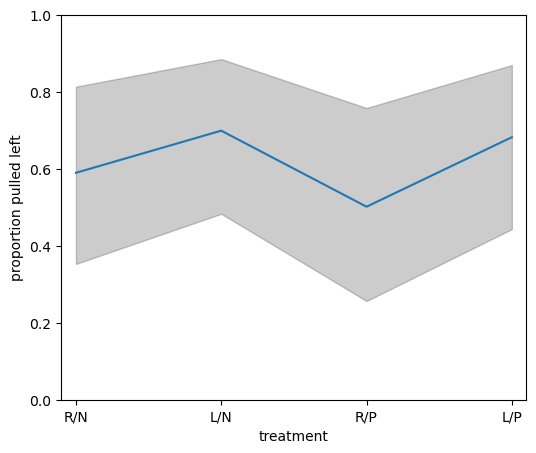

In [101]:
p_raw = list(map(p_link_abar, np.arange(4)))
p_mu = np.mean(p_raw, 1)
p_ci = np.percentile(p_raw, (5.5, 94.5), 1)

plt.subplot(
    xlabel="treatment", ylabel="proportion pulled left", ylim=(0, 1), xlim=(0.9, 4.1)
)
plt.gca().set(xticks=range(1, 5), xticklabels=["R/N", "L/N", "R/P", "L/P"])
plt.plot(range(1, 5), p_mu)
plt.fill_between(range(1, 5), p_ci[0], p_ci[1], color="k", alpha=0.2)
plt.show()

##### Code 13.38

In [102]:
a_sim = tfd.Normal(
    loc=post_4_dict["a_bar"][0], scale=post_4_dict["sigma_a"][0]).sample(seed=key())

def p_link_asim(treatment):
    logodds = a_sim + post_4_dict["b"][0][:, treatment]
    return jax.nn.sigmoid(logodds)

p_raw_asim = np.array(list(map(p_link_asim, np.arange(4))))

##### Code 13.39

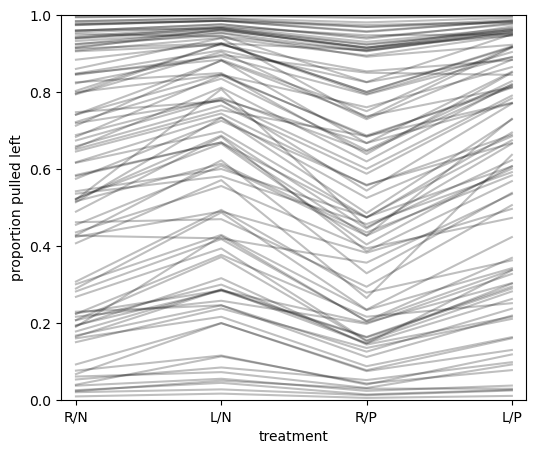

In [103]:
plt.subplot(
    xlabel="treatment", ylabel="proportion pulled left", ylim=(0, 1), xlim=(0.9, 4.1)
)
plt.gca().set(xticks=range(1, 5), xticklabels=["R/N", "L/N", "R/P", "L/P"])
for i in range(100):
    plt.plot(range(1, 5), p_raw_asim[:, i], color="k", alpha=0.25)